<a href="https://colab.research.google.com/github/sahilk45/Next-Word-Predictor/blob/main/bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Emotion Recognition with Bi-LSTM - Complete End-to-End Pipeline
Dataset Structure:
    dataset/
    ├── Anger/
    ├── Disgust/
    ├── Fear/
    ├── Happy/
    ├── Sad/
    └── Neutral/
"""

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

warnings.filterwarnings('ignore')


In [ ]:
!pip install seaborn

In [ ]:

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_seed(SEED)

CONFIG = {
    'random_seed': SEED,
    'dataset_path': './home/staru/audio_aug/aug_carhorn_audio',
    'sr': 16000,
    'n_mfcc': 40,
    'n_fft': 2048,
    'hop_length': 512,
    'max_duration': 10.0,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'lstm_hidden_size': 256,
    'lstm_num_layers': 2,
    'dropout': 0.3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

EMOTIONS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']
EMOTION_TO_IDX = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
IDX_TO_EMOTION = {idx: emotion for emotion, idx in EMOTION_TO_IDX.items()}

print('✓ Configuration loaded')
print(f'  Device: {CONFIG["device"]}')
print(f'  Emotions: {EMOTIONS}')


✓ Configuration loaded
  Device: cuda
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']


In [ ]:

# ============================================================================
# 2. FEATURE EXTRACTION
# ============================================================================

def extract_mfcc_features(audio_path, sr=16000, n_mfcc=40, n_fft=2048, hop_length=512, max_duration=10.0):
    """Extract MFCC features from audio file."""
    try:
        y, _ = librosa.load(audio_path, sr=sr, duration=max_duration)

        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )

        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta_delta = librosa.feature.delta(mfcc, order=2)

        features = np.vstack([mfcc, mfcc_delta, mfcc_delta_delta])

        return features.T
    except Exception as e:
        print(f'Error extracting features from {audio_path}: {e}')
        return None

print('✓ Feature extraction function defined')


✓ Feature extraction function defined


In [ ]:

# ============================================================================
# 3. DATA LOADING
# ============================================================================

def load_audio_data(dataset_path, emotions=EMOTIONS):
    """Load audio files from emotion folders."""
    file_paths = []
    stats = defaultdict(int)
    errors = []

    for emotion in emotions:
        emotion_dir = os.path.join(dataset_path, emotion)

        if not os.path.exists(emotion_dir):
            print(f'⚠ Warning: {emotion_dir} not found')
            continue

        audio_files = []
        for ext in ['*.mp3', '*.wav', '*.ogg', '*.flac']:
            audio_files.extend(Path(emotion_dir).glob(ext))

        for audio_path in audio_files:
            try:
                y, _ = librosa.load(str(audio_path), sr=CONFIG['sr'], duration=CONFIG['max_duration'])
                if len(y) > 0:
                    file_paths.append((str(audio_path), emotion))
                    stats[emotion] += 1
            except Exception as e:
                errors.append((str(audio_path), str(e)))

    print('\n✓ Dataset loaded successfully')
    print('Samples per emotion:')
    for emotion in emotions:
        count = stats.get(emotion, 0)
        print(f'  {emotion}: {count}')
    print(f'Total samples: {sum(stats.values())}')

    if errors:
        print(f'⚠ {len(errors)} files had errors')

    return file_paths, dict(stats)


print('Loading dataset...')
file_paths, stats = load_audio_data('/home/staru/audio_aug/aug_carhorn_audio')

Loading dataset...

✓ Dataset loaded successfully
Samples per emotion:
  Anger: 1350
  Disgust: 1350
  Fear: 1350
  Happy: 1350
  Sad: 1350
  Neutral: 1350
Total samples: 8100


In [ ]:

# ============================================================================
# 4. STRATIFIED SPLIT
# ============================================================================

def stratified_split(file_paths, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """Stratified split maintaining emotion distribution."""
    emotion_groups = defaultdict(list)
    for path, emotion in file_paths:
        emotion_groups[emotion].append((path, emotion))

    train_set, val_set, test_set = [], [], []
    np.random.seed(seed)

    for emotion, samples in emotion_groups.items():
        np.random.shuffle(samples)
        n_train = int(len(samples) * train_ratio)
        n_val = int(len(samples) * val_ratio)

        train_set.extend(samples[:n_train])
        val_set.extend(samples[n_train:n_train+n_val])
        test_set.extend(samples[n_train+n_val:])

    return train_set, val_set, test_set

train_set, val_set, test_set = stratified_split(file_paths, seed=SEED)

print('✓ Data split completed')
print(f'  Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}')


✓ Data split completed
  Train: 6480, Val: 810, Test: 810


In [ ]:

# ============================================================================
# 5. EXTRACT FEATURES
# ============================================================================

def extract_all_features(file_list, config):
    """Extract MFCC features for all audio files."""
    features_list = []
    labels_list = []
    valid_paths = []

    print(f'\nExtracting features from {len(file_list)} samples...')

    for audio_path, emotion in tqdm(file_list, desc='Feature extraction'):
        try:
            mfcc = extract_mfcc_features(
                audio_path,
                sr=config['sr'],
                n_mfcc=config['n_mfcc'],
                n_fft=config['n_fft'],
                hop_length=config['hop_length'],
                max_duration=config['max_duration']
            )

            if mfcc is not None:
                features_list.append(mfcc)
                labels_list.append(EMOTION_TO_IDX[emotion])
                valid_paths.append(audio_path)
        except Exception as e:
            print(f'Error processing {audio_path}: {e}')

    print(f'✓ Extracted features from {len(features_list)} samples')
    return features_list, labels_list, valid_paths

print('\n' + '='*60)
print('EXTRACTING MFCC FEATURES')
print('='*60)

train_features, train_labels, train_paths = extract_all_features(train_set, CONFIG)
val_features, val_labels, val_paths = extract_all_features(val_set, CONFIG)
test_features, test_labels, test_paths = extract_all_features(test_set, CONFIG)



EXTRACTING MFCC FEATURES

Extracting features from 6480 samples...


Feature extraction: 100%|██████████| 6480/6480 [00:32<00:00, 199.01it/s]


✓ Extracted features from 6480 samples

Extracting features from 810 samples...


Feature extraction: 100%|██████████| 810/810 [00:04<00:00, 199.54it/s]


✓ Extracted features from 810 samples

Extracting features from 810 samples...


Feature extraction: 100%|██████████| 810/810 [00:04<00:00, 199.28it/s]

✓ Extracted features from 810 samples


In [ ]:

# ============================================================================
# 6. DATASET CLASS
# ============================================================================

class EmotionAudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])[0]

        return {
            'features': feature,
            'labels': label
        }

def collate_fn(batch):
    """Custom collate function to pad sequences."""
    features = [item['features'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])

    features_padded = pad_sequence(features, batch_first=True)

    return {
        'features': features_padded,
        'labels': labels
    }

train_dataset = EmotionAudioDataset(train_features, train_labels)
val_dataset = EmotionAudioDataset(val_features, val_labels)
test_dataset = EmotionAudioDataset(test_features, test_labels)

print('✓ Dataset classes created')


✓ Dataset classes created


In [ ]:

# ============================================================================
# 7. CREATE DATA LOADERS
# ============================================================================

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

print('✓ Data loaders created')
print(f'  Train batches: {len(train_loader)}')
print(f'  Val batches: {len(val_loader)}')
print(f'  Test batches: {len(test_loader)}')


✓ Data loaders created
  Train batches: 203
  Val batches: 26
  Test batches: 26


In [ ]:

# ============================================================================
# 8. BI-LSTM MODEL
# ============================================================================

class BiLSTMEmotionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(BiLSTMEmotionModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.bilstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout1 = nn.Dropout(dropout)

        self.bilstm2 = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0
        )

        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        lstm_out1, _ = self.bilstm1(x)
        lstm_out1 = self.dropout1(lstm_out1)

        lstm_out2, (h_n, c_n) = self.bilstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        lstm_avg = torch.mean(lstm_out2, dim=1)

        dense_out = self.fc1(lstm_avg)
        dense_out = self.relu(dense_out)
        logits = self.fc2(dense_out)

        return logits

feature_dim = 120
model = BiLSTMEmotionModel(
    input_size=feature_dim,
    hidden_size=CONFIG['lstm_hidden_size'],
    num_layers=CONFIG['lstm_num_layers'],
    num_classes=len(EMOTIONS),
    dropout=CONFIG['dropout']
)

model = model.to(CONFIG['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('✓ Bi-LSTM model created')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable parameters: {trainable_params:,}')


✓ Bi-LSTM model created
  Total parameters: 3,994,502
  Trainable parameters: 3,994,502


In [ ]:

# ============================================================================
# 9. TRAINING SETUP
# ============================================================================

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print('✓ Optimizer and scheduler configured')


✓ Optimizer and scheduler configured


In [ ]:

# ============================================================================
# 10. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': loss.item()})

    #avg_loss = total_loss / len(dataloader)
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #avg_loss = total_loss / len(dataverbose=Trueloader)
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels

print('✓ Training functions defined')


✓ Training functions defined


In [ ]:

# ============================================================================
# 11. TRAINING LOOP
# ============================================================================

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience = 10
patience_counter = 0

print('\n' + '='*60)
print('TRAINING')
print('='*60)

for epoch in range(CONFIG['epochs']):
    print(f'\nEpoch [{epoch+1}/{CONFIG["epochs"]}]')

    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, CONFIG['device']
    )

    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CONFIG['device'])

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'bilstm_emotion_model.pt')
        print('  ✓ Model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\n⏹ Early stopping after {epoch+1} epochs')
            break

print('\n' + '='*60)
print('✓ Training completed')



TRAINING

Epoch [1/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 128.89it/s]


  Train Loss: 0.7913 | Train Acc: 0.6765
  Val Loss: 0.9986 | Val Acc: 0.6370
  ✓ Model saved

Epoch [2/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 133.60it/s]


  Train Loss: 0.7126 | Train Acc: 0.7225
  Val Loss: 0.9234 | Val Acc: 0.6346
  ✓ Model saved

Epoch [3/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 133.55it/s]


  Train Loss: 0.6111 | Train Acc: 0.7647
  Val Loss: 0.9060 | Val Acc: 0.6691
  ✓ Model saved

Epoch [4/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 128.58it/s]


  Train Loss: 0.5439 | Train Acc: 0.7872
  Val Loss: 0.8667 | Val Acc: 0.7123
  ✓ Model saved

Epoch [5/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 126.22it/s]


  Train Loss: 0.4675 | Train Acc: 0.8216
  Val Loss: 0.7374 | Val Acc: 0.7321
  ✓ Model saved

Epoch [6/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 129.01it/s]


  Train Loss: 0.4136 | Train Acc: 0.8454
  Val Loss: 0.7996 | Val Acc: 0.7457

Epoch [7/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 121.01it/s]


  Train Loss: 0.3538 | Train Acc: 0.8676
  Val Loss: 0.8224 | Val Acc: 0.7272

Epoch [8/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 128.15it/s]


  Train Loss: 0.3160 | Train Acc: 0.8870
  Val Loss: 0.7007 | Val Acc: 0.7852
  ✓ Model saved

Epoch [9/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 127.87it/s]


  Train Loss: 0.3012 | Train Acc: 0.8924
  Val Loss: 0.7578 | Val Acc: 0.7691

Epoch [10/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 121.95it/s]


  Train Loss: 0.2645 | Train Acc: 0.9015
  Val Loss: 0.8929 | Val Acc: 0.7432

Epoch [11/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 123.74it/s]


  Train Loss: 0.2428 | Train Acc: 0.9128
  Val Loss: 0.7803 | Val Acc: 0.7951

Epoch [12/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 132.25it/s]


  Train Loss: 0.2061 | Train Acc: 0.9272
  Val Loss: 0.9735 | Val Acc: 0.7420

Epoch [13/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 133.59it/s]


  Train Loss: 0.1911 | Train Acc: 0.9367
  Val Loss: 0.9949 | Val Acc: 0.7580

Epoch [14/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 133.07it/s]


  Train Loss: 0.1703 | Train Acc: 0.9420
  Val Loss: 0.8421 | Val Acc: 0.7889

Epoch [15/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 121.44it/s]


  Train Loss: 0.0938 | Train Acc: 0.9673
  Val Loss: 0.9362 | Val Acc: 0.8025

Epoch [16/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 125.33it/s]


  Train Loss: 0.0480 | Train Acc: 0.9866
  Val Loss: 1.1952 | Val Acc: 0.7951

Epoch [17/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 136.04it/s]


  Train Loss: 0.0425 | Train Acc: 0.9881
  Val Loss: 1.3445 | Val Acc: 0.7975

Epoch [18/50]


Validating: 100%|██████████| 26/26 [00:00<00:00, 129.58it/s]

  Train Loss: 0.0458 | Train Acc: 0.9864
  Val Loss: 1.2830 | Val Acc: 0.8086

⏹ Early stopping after 18 epochs

✓ Training completed


In [ ]:

# ============================================================================
# 12. EVALUATION
# ============================================================================

model.load_state_dict(torch.load('bilstm_emotion_model.pt'))

test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, CONFIG['device']
)

print('\n' + '='*60)
print('TEST RESULTS')
print('='*60)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'\nClassification Report:\n')
print(classification_report(test_labels, test_preds, target_names=EMOTIONS))


Validating: 100%|██████████| 26/26 [00:00<00:00, 109.84it/s]


TEST RESULTS
Test Loss: 0.7128
Test Accuracy: 0.7704

Classification Report:

              precision    recall  f1-score   support

       Anger       0.94      0.84      0.89       135
     Disgust       0.78      0.61      0.68       135
        Fear       0.88      0.68      0.77       135
       Happy       0.64      0.80      0.71       135
         Sad       0.68      0.86      0.76       135
     Neutral       0.80      0.83      0.81       135

    accuracy                           0.77       810
   macro avg       0.79      0.77      0.77       810
weighted avg       0.79      0.77      0.77       810



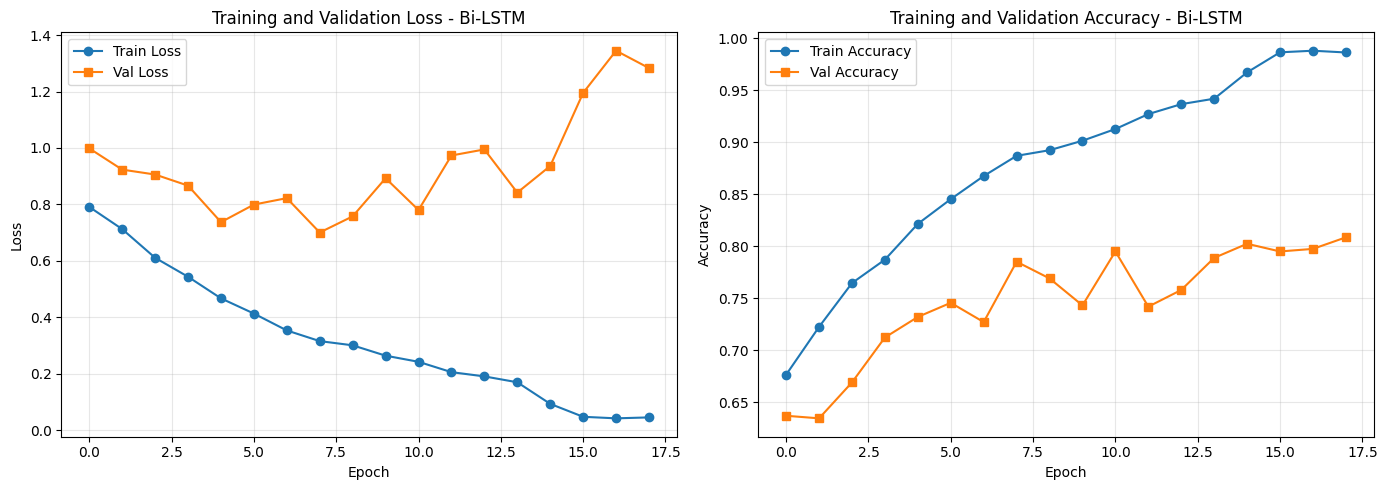

✓ Training history plot saved


In [ ]:

# ============================================================================
# 13. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss - Bi-LSTM')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy - Bi-LSTM')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bilstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Training history plot saved')


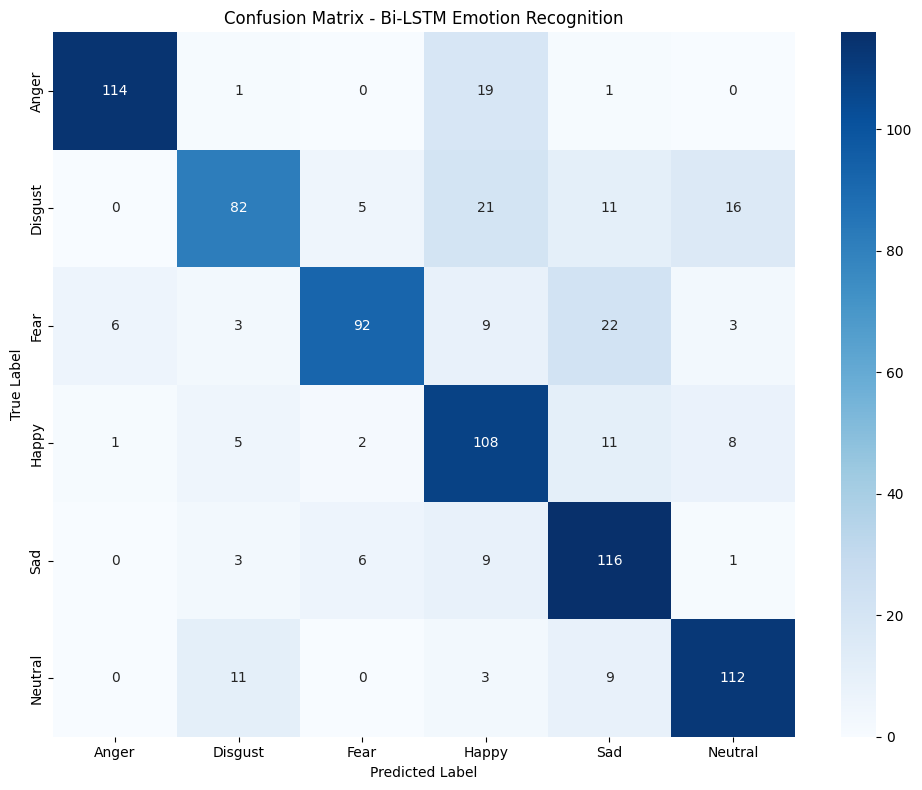

✓ Confusion matrix plot saved


In [ ]:

# ============================================================================
# 14. CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Confusion Matrix - Bi-LSTM Emotion Recognition')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('bilstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Confusion matrix plot saved')



Per-Emotion Metrics:
Emotion  Precision   Recall  F1-Score  Support
  Anger   0.942149 0.844444  0.890625      135
Disgust   0.780952 0.607407  0.683333      135
   Fear   0.876190 0.681481  0.766667      135
  Happy   0.639053 0.800000  0.710526      135
    Sad   0.682353 0.859259  0.760656      135
Neutral   0.800000 0.829630  0.814545      135


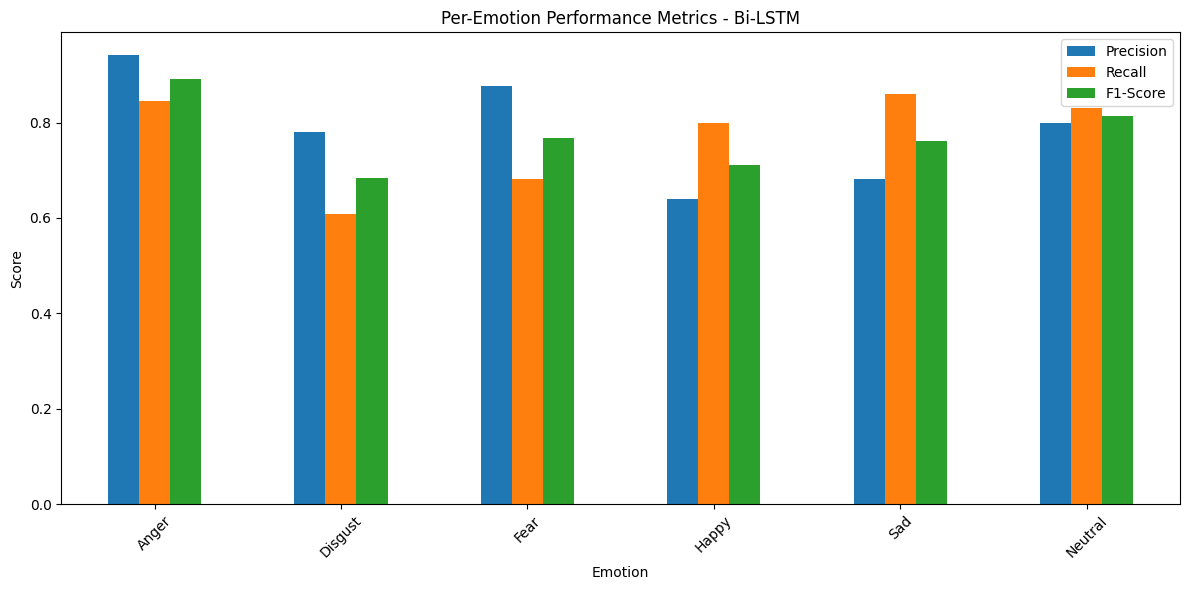

✓ Per-emotion metrics plot saved


In [ ]:

# ============================================================================
# 15. PER-EMOTION METRICS
# ============================================================================

precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, labels=range(len(EMOTIONS))
)

metrics_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print('\nPer-Emotion Metrics:')
print(metrics_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.set_index('Emotion')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=ax)
plt.title('Per-Emotion Performance Metrics - Bi-LSTM')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('bilstm_per_emotion_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Per-emotion metrics plot saved')


In [ ]:

# ============================================================================
# 16. INFERENCE
# ============================================================================

def predict_emotion(audio_path, model, config, device):
    """Predict emotion for a single audio file."""
    model.eval()

    mfcc = extract_mfcc_features(
        audio_path,
        sr=config['sr'],
        n_mfcc=config['n_mfcc'],
        n_fft=config['n_fft'],
        hop_length=config['hop_length'],
        max_duration=config['max_duration']
    )

    if mfcc is None:
        return None

    features = torch.FloatTensor(mfcc).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(features)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_id = torch.argmax(outputs, dim=1).item()
        predicted_emotion = IDX_TO_EMOTION[predicted_id]
        confidence = probabilities[0, predicted_id].item()

    return {
        'predicted_emotion': predicted_emotion,
        'confidence': confidence,
        'probabilities': {
            EMOTIONS[i]: probabilities[0, i].item()
            for i in range(len(EMOTIONS))
        }
    }

if len(test_paths) > 0:
    test_audio_path = test_paths[0]

    result = predict_emotion(test_audio_path, model, CONFIG, CONFIG['device'])

    if result:
        print('\nExample Prediction:')
        print(f'  Audio: {os.path.basename(test_audio_path)}')
        print(f'  Predicted Emotion: {result["predicted_emotion"]}')
        print(f'  Confidence: {result["confidence"]*100:.2f}%')
        print(f'\n  All Probabilities:')
        for emotion, prob in result['probabilities'].items():
            print(f'    {emotion}: {prob*100:.2f}%')



Example Prediction:
  Audio: A13_EN_A_S18_time_mask.wav
  Predicted Emotion: Fear
  Confidence: 57.50%

  All Probabilities:
    Anger: 42.28%
    Disgust: 0.05%
    Fear: 57.50%
    Happy: 0.17%
    Sad: 0.00%
    Neutral: 0.00%


In [ ]:
"""
# ============================================================================
# 17. SAVE RESULTS
# ============================================================================

torch.save(model, 'bilstm_emotion_model_full.pth')

results = {
    'model': 'Bi-LSTM',
    'config': CONFIG,
    'emotions': EMOTIONS,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'metrics': metrics_df.to_dict(),
    'confusion_matrix': cm.tolist()
}

results['config']['device'] = str(results['config']['device'])

with open('bilstm_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('\n✓ Model and results saved successfully')
print('  - Model: bilstm_emotion_model_full.pth')
print('  - Results: bilstm_results.json')

"""

# ============================================================================
# 17. SAVE RESULTS (Pitch Shift Augmentation)
# ============================================================================

torch.save(model, 'bilstm_pitchshift_model_full.pth')

results = {
    'model': 'Bi-LSTM (Pitch Shift)',
    'config': CONFIG,
    'emotions': EMOTIONS,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'metrics': metrics_df.to_dict(),
    'confusion_matrix': cm.tolist()
}

results['config']['device'] = str(results['config']['device'])

with open('bilstm_pitchshift_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('\n✓ Model and results saved successfully (Pitch Shift)')
print('  - Model: bilstm_pitchshift_model_full.pth')
print('  - Results: bilstm_pitchshift_results.json')




✓ Model and results saved successfully (Pitch Shift)
  - Model: bilstm_pitchshift_model_full.pth
  - Results: bilstm_pitchshift_results.json


In [ ]:
"""
# ============================================================================
# 18. SUMMARY
# ============================================================================

print('\n' + '='*60)
print('EMOTION RECOGNITION WITH BI-LSTM - SUMMARY')
print('='*60)
print(f'\nDataset:')
print(f'  Total samples: {len(file_paths)}')
print(f'  Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}')
print(f'\nFeature Extraction:')
print(f'  MFCC Coefficients: {CONFIG["n_mfcc"]}')
print(f'  Total Features: 120 (MFCC + Delta + Delta-Delta)')
print(f'\nModel:')
print(f'  Architecture: Bi-LSTM')
print(f'  Hidden Size: {CONFIG["lstm_hidden_size"]}')
print(f'  Num Layers: {CONFIG["lstm_num_layers"]}')
print(f'  Total parameters: {total_params:,}')
print(f'\nResults:')
print(f'  Test Accuracy: {test_acc:.4f}')
print(f'  Test Loss: {test_loss:.4f}')
print(f'  Emotions: {EMOTIONS}')
print('='*60)

"""

# ============================================================================
# 18. SUMMARY
# ============================================================================

AUG_NAME = "Time Mask"   # <-- CHANGE THIS NAME ONLY

print('\n' + '='*60)
print(f'EMOTION RECOGNITION WITH BI-LSTM ({AUG_NAME}) - SUMMARY')
print('='*60)

print(f'\nDataset:')
print(f'  Total samples: {len(file_paths)}')
print(f'  Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}')

print(f'\nData Augmentation:')
print(f'  Applied Augmentation: {AUG_NAME}')

print(f'\nFeature Extraction:')
print(f'  MFCC Coefficients: {CONFIG["n_mfcc"]}')
print(f'  Total Features: 120 (MFCC + Delta + Delta-Delta)')

print(f'\nModel:')
print(f'  Architecture: Bi-LSTM')
print(f'  Hidden Size: {CONFIG["lstm_hidden_size"]}')
print(f'  Num Layers: {CONFIG["lstm_num_layers"]}')
print(f'  Total parameters: {total_params:,}')

print(f'\nResults:')
print(f'  Test Accuracy: {test_acc:.4f}')
print(f'  Test Loss: {test_loss:.4f}')
print(f'  Emotions: {EMOTIONS}')

print('='*60)



EMOTION RECOGNITION WITH BI-LSTM (Time Mask) - SUMMARY

Dataset:
  Total samples: 8100
  Train: 6480, Val: 810, Test: 810

Data Augmentation:
  Applied Augmentation: Time Mask

Feature Extraction:
  MFCC Coefficients: 40
  Total Features: 120 (MFCC + Delta + Delta-Delta)

Model:
  Architecture: Bi-LSTM
  Hidden Size: 256
  Num Layers: 2
  Total parameters: 3,994,502

Results:
  Test Accuracy: 0.7704
  Test Loss: 0.7128
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']
